In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import numpy as np
import math, random

In [2]:
# Generating a noisy multi-sin wave 

def sine_2(X, signal_freq=60.):
    return (np.sin(2 * np.pi * (X) / signal_freq) + np.sin(4 * np.pi * (X) / signal_freq)) / 2.0

def noisy(Y, noise_range=(-0.05, 0.05)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise

def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    Y = noisy(sine_2(X + random_offset))
    return Y

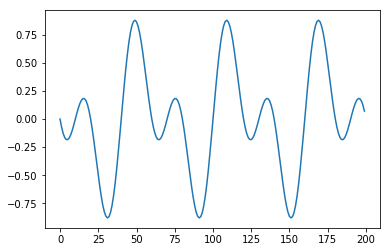

In [12]:
plt.plot([sine_2(x) for x in range(-100, 100)])

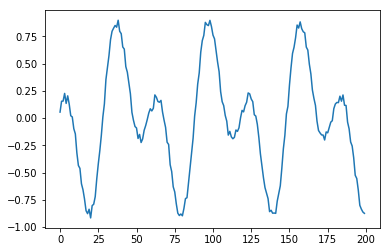

In [13]:
plt.plot(sample(200))

In [16]:
# Pytorch’s LSTM expects all of its inputs to be 3D tensors. The semantics of the axes of these tensors is 
# important. The first axis is the sequence itself, the second indexes instances in the mini-batch, and the 
# third indexes elements of the input.

rnn = nn.LSTM(10, 20, 2)
input = Variable(torch.randn(5, 3, 10))
h0 = Variable(torch.randn(2, 3, 20))
c0 = Variable(torch.randn(2, 3, 20))
output, hn = rnn(input, (h0, c0))

In [19]:
h0

Variable containing:
(0 ,.,.) = 

Columns 0 to 8 
   1.7293 -0.0163 -0.0251  2.3274  0.6641  1.3219 -1.1642  0.0453 -0.0142
  0.8889 -0.3206 -0.1177  0.6767 -0.7929  0.0711 -0.6284  1.2135  1.0848
  0.1078 -0.9802 -0.9487  0.4100  0.0311 -0.6894 -1.3375 -0.8189  0.5249

Columns 9 to 17 
   1.0173  0.1226 -0.0649 -0.5659 -0.1463 -0.3845 -0.3890 -1.6858  1.7872
  0.6859 -0.7268  0.9984  1.3237  0.1939 -0.6166  0.3462 -0.3892 -1.4237
 -0.2941  0.4585  0.4283  0.3844  0.9623 -0.5266  0.5678  1.3970  1.1821

Columns 18 to 19 
   1.8872  0.0082
 -0.3668 -1.0001
 -1.8082 -1.3624

(1 ,.,.) = 

Columns 0 to 8 
   0.5717 -0.4582 -0.6923  1.4355 -0.1379 -0.3721  1.1175 -0.6765  1.5640
  0.8444  2.1374 -0.4656  1.3975  0.1009  0.9436 -1.5843  3.4579 -0.2281
  0.6261  0.4367  0.5518 -1.3723 -0.5028 -0.9419 -0.9151  0.8823  0.1616

Columns 9 to 17 
   1.0526 -0.5401 -0.2940 -0.2808 -1.8043 -0.1940 -1.7918  0.0072  1.0650
  0.5834  0.7007  0.0440  0.5499 -0.3048 -0.1130  1.0432 -0.3694  0.0692
  0.88

In [14]:
# Define the model

class SimpleRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size

        self.inp = nn.Linear(1, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, 2, dropout=0.05)
        self.out = nn.Linear(hidden_size, 1)

    def step(self, input, hidden=None):
        input = self.inp(input.view(1, -1)).unsqueeze(1)
        output, hidden = self.rnn(input, hidden)
        output = self.out(output.squeeze(1))
        return output, hidden

    def forward(self, inputs, hidden=None, force=True, steps=0):
        if force or steps == 0: steps = len(inputs)
        outputs = Variable(torch.zeros(steps, 1, 1))
        for i in range(steps):
            if force or i == 0:
                input = inputs[i]
            else:
                input = output
            output, hidden = self.step(input, hidden)
            outputs[i] = output
        return outputs, hidden

In [15]:
n_epochs = 100
n_iters = 50
hidden_size = 10

model = SimpleRNN(hidden_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

losses = np.zeros(n_epochs) # For plotting

for epoch in range(n_epochs):

    for iter in range(n_iters):
        _inputs = sample(50)
        inputs = Variable(torch.from_numpy(_inputs[:-1]).float())
        targets = Variable(torch.from_numpy(_inputs[1:]).float())

        # Use teacher forcing 50% of the time
        force = random.random() < 0.5
        outputs, hidden = model(inputs, None, force)

        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        losses[epoch] += loss.data[0]

    if epoch > 0:
        print(epoch, loss.data[0])

    # Use some plotting library
    # if epoch % 10 == 0:
        # show_plot('inputs', _inputs, True)
        # show_plot('outputs', outputs.data.view(-1), True)
        # show_plot('losses', losses[:epoch] / n_iters)

        # Generate a test
        # outputs, hidden = model(inputs, False, 50)
        # show_plot('generated', outputs.data.view(-1), True)

# Online training
hidden = None

while True:
    inputs = get_latest_sample()
    outputs, hidden = model(inputs, hidden)

    optimizer.zero_grad()
    loss = criterion(outputs, inputs)
    loss.backward()
    optimizer.step()

1 0.2355068176984787
2 0.17369042336940765
3 0.2908271551132202
4 0.16700375080108643
5 0.30450204014778137
6 0.2314186543226242
7 0.2963598072528839
8 0.2751900851726532
9 0.2595076262950897
10 0.2680564224720001
11 0.19584956765174866
12 0.2901574671268463
13 0.16679097712039948
14 0.183042973279953
15 0.2866426110267639
16 0.2907291650772095
17 0.16587607562541962
18 0.22089184820652008
19 0.28970593214035034
20 0.22028325498104095
21 0.10523685067892075
22 0.29376843571662903
23 0.3144527077674866
24 0.24508807063102722
25 0.21793055534362793
26 0.23899662494659424
27 0.10328630357980728
28 0.11117728054523468
29 0.11237353086471558
30 0.1113172098994255
31 0.08755378425121307
32 0.3068101406097412
33 0.10504524409770966
34 0.11043249815702438
35 0.2986127436161041
36 0.09865276515483856
37 0.10059090703725815
38 0.07983634620904922
39 0.2837156057357788
40 0.1666974276304245
41 0.09086772054433823
42 0.1421974152326584
43 0.07944877445697784
44 0.35665324330329895
45 0.30876556038

KeyboardInterrupt: 

In [22]:
help(nn.Embedding)

Help on class Embedding in module torch.nn.modules.sparse:

class Embedding(torch.nn.modules.module.Module)
 |  A simple lookup table that stores embeddings of a fixed dictionary and size.
 |  
 |  This module is often used to store word embeddings and retrieve them using indices.
 |  The input to the module is a list of indices, and the output is the corresponding
 |  word embeddings.
 |  
 |  Args:
 |      num_embeddings (int): size of the dictionary of embeddings
 |      embedding_dim (int): the size of each embedding vector
 |      padding_idx (int, optional): If given, pads the output with zeros whenever it encounters the index.
 |      max_norm (float, optional): If given, will renormalize the embeddings to always have a norm lesser than this
 |      norm_type (float, optional): The p of the p-norm to compute for the max_norm option
 |      scale_grad_by_freq (boolean, optional): if given, this will scale gradients by the frequency of
 |                                           

Okay, so let's try the notebook by Hun Kim, as it looks much simplre and is hopefully manageable to implement and use.

In [ ]:
# Lab 12 RNN
import sys
import torch
import torch.nn as nn
from torch.autograd import Variable

In [ ]:
torch.manual_seed(777)  # reproducibility
#            0    1    2    3    4
idx2char = ['h', 'i', 'e', 'l', 'o']

# Teach hihell -> ihello
x_data = [0, 1, 0, 2, 3, 3]   # hihell
one_hot_lookup = [[1, 0, 0, 0, 0],  # 0
                  [0, 1, 0, 0, 0],  # 1
                  [0, 0, 1, 0, 0],  # 2
                  [0, 0, 0, 1, 0],  # 3
                  [0, 0, 0, 0, 1]]  # 4

y_data = [1, 0, 2, 3, 3, 4]    # ihello
x_one_hot = [one_hot_lookup[x] for x in x_data]

# As we have one batch of samples, we will change them to variables only once
inputs = Variable(torch.Tensor(x_one_hot))
labels = Variable(torch.LongTensor(y_data))

In [38]:
a = nn.LSTM(input_size=input_size,hidden_size=hidden_size, batch_first=True)

In [50]:
x = Variable(torch.Tensor([1, 2, 3, 12, 13]))

In [52]:
x

Variable containing:
(0 ,.,.) = 
   1   2   3  12  13
[torch.FloatTensor of size 1x1x5]

In [51]:
x = x.view(batch_size, sequence_length, input_size)

In [40]:
a.

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_all_buffers',
 '_all_weights',
 '_apply',
 '_backend',
 '_backward_hooks',
 '_buffers',
 '_data_ptrs',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_modules',
 '_parameters',
 '_slow_forward',
 '_tracing_name',
 'add_module',
 'all_weights',
 'apply',
 'batch_first',
 'bias',
 'bias_hh_l0',
 'bias_ih_l0',
 'bidirectional',
 'check_forward_args',
 'children',
 'cpu',
 'cuda',
 'double',
 'dropout',
 'dropout_state',
 'dump_patches',
 'eval',
 'flatten_parameters',
 'float',
 'forward',
 'half',
 'hidden_size',
 'input_size',
 'load_state_dict',
 'mode',
 'modules',
 'named_chi

In [29]:
torch.manual_seed(777)  # reproducibility
#            0    1    2    3    4
idx2char = ['h', 'i', 'e', 'l', 'o']

# Teach hihell -> ihello
x_data = [0, 1, 0, 2, 3, 3]   # hihell
one_hot_lookup = [[1, 0, 0, 0, 0],  # 0
                  [0, 1, 0, 0, 0],  # 1
                  [0, 0, 1, 0, 0],  # 2
                  [0, 0, 0, 1, 0],  # 3
                  [0, 0, 0, 0, 1]]  # 4

y_data = [1, 0, 2, 3, 3, 4]    # ihello
x_one_hot = [one_hot_lookup[x] for x in x_data]

# As we have one batch of samples, we will change them to variables only once
inputs = Variable(torch.Tensor(x_one_hot))
labels = Variable(torch.LongTensor(y_data))

num_classes = 5
input_size = 5  # one-hot size
hidden_size = 5  # output from the RNN. 5 to directly predict one-hot
batch_size = 1   # one sentence
sequence_length = 1  # One by one
num_layers = 1  # one-layer rnn


class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                          hidden_size=hidden_size, batch_first=True)

    def forward(self, hidden, x):
        # Reshape input (batch first)
        x = x.view(batch_size, sequence_length, input_size)

        # Propagate input through RNN
        # Input: (batch, seq_len, input_size)
        # hidden: (num_layers * num_directions, batch, hidden_size)
        out, hidden = self.lstm(x, hidden)
        return hidden, out.view(-1, num_classes)

    def init_hidden(self):
        # Initialize hidden and cell states
        # (num_layers * num_directions, batch, hidden_size)
        return Variable(torch.zeros(num_layers, batch_size, hidden_size))

In [32]:
# Instantiate RNN model
model = Model()
print(model)

Model(
  (lstm): LSTM(5, 5, batch_first=True)
)


In [36]:
hidden

Variable containing:
(0 ,.,.) = 
  0  0  0  0  0
[torch.FloatTensor of size 1x1x5]

In [34]:
# hidden, output = 
model(hidden, input)

RuntimeError: Expected hidden[0] size (1, 1, 5), got (1, 5)

In [31]:
# Set loss and optimizer function
# CrossEntropyLoss = LogSoftmax + NLLLoss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Train the model
for epoch in range(100):
    optimizer.zero_grad()
    loss = 0
    hidden = model.init_hidden()

    sys.stdout.write("predicted string: ")
    for input, label in zip(inputs, labels):
        # print(input.size(), label.size())
        hidden, output = model(hidden, input)
        val, idx = output.max(1)
        sys.stdout.write(idx2char[idx.data[0]])
        loss += criterion(output, label)

    print(", epoch: %d, loss: %1.3f" % (epoch + 1, loss.data[0]))

    loss.backward()
    optimizer.step()

print("Learning finished!")

predicted string: 

RuntimeError: Expected hidden[0] size (1, 1, 5), got (1, 5)